## New main file

In [ ]:
import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 
from MJP.myplotMJ import * 

date_initial='2000-01-01'
date_final='2023-12-31'

# if True delete stocks lower than 5th and higher than 95th NYSE ME percentile
remove_outliers = False # False True
inf=None
sup=None

factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})



df=pd.read_csv('monthly_data.csv')
df['date']=pd.to_datetime(df['date'])


## configurazione base:
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': True,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}

if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'


factors=factors_df['factors'].to_list()


In [ ]:
import matplotlib.pyplot as plt

### COMPUTE SINGLE FACTOR STRATEGIES
portfolios, weighted_portfolios, portfolios_stock_reallocation = compute_factor_strategies(df, MJ_configuration)


### COMPUTE EQUAL WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=False
MJ_portfolios, \
mj_voters, \
MJ_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df, 
                                                            MJ_configuration)


### COMPUTE VALUE WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=True
MJ_weighted_portfolios, \
mj_voters, \
MJ_weighted_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df, 
                                                            MJ_configuration)

### MERGE PORTFOLIO RESULTS
portfolios['mj']=MJ_portfolios['mj']
weighted_portfolios['wmj']=MJ_weighted_portfolios['wmj']

### MERGE REALLOCATION RESULTS
portfolios_stock_reallocation['mj']={}
portfolios_stock_reallocation['wmj']={}
portfolios_stock_reallocation['mj']['EW_turnover']=MJ_portfolios_stock_reallocation['mj']
portfolios_stock_reallocation['wmj']['VW_turnover']=MJ_weighted_portfolios_stock_reallocation['wmj']


<Axes: xlabel='medate'>

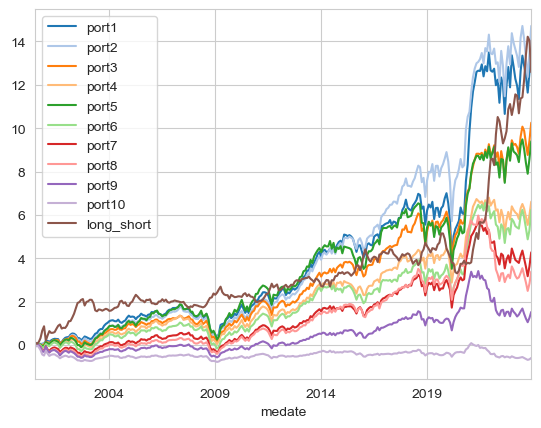

In [10]:
#PLOT THE RESULTS OF SINGLA FACTOR SORTING FOR A GIVEN FACTOR

factor='ns'
((1+portfolios[factor]).cumprod()-1).plot()

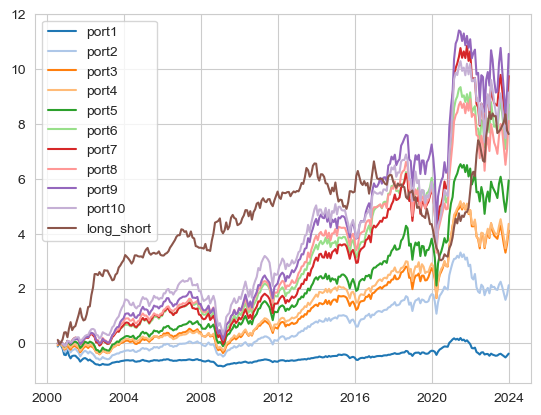

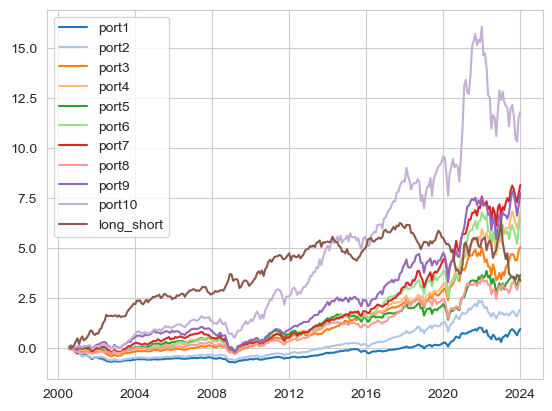

In [12]:
# Plot cumulative returns of EW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['mj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# Plot cumulative returns of VW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+weighted_portfolios['wmj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()


In [13]:
list_reallocation={}
list_reallocation['even']=[]
list_reallocation['weighted']=[]


for factor in factors+['mj']:
    for port in range(1,MJ_configuration['num_port']+1):
        list_reallocation['even'].append([factor,port,portfolios_stock_reallocation[factor]['EW_turnover'].iloc[int(port)-1].iloc[1]])
        
for factor in factors+['wmj']:
    for port in range(1,MJ_configuration['num_port']+1):
        list_reallocation['weighted'].append([factor,port,portfolios_stock_reallocation[factor]['VW_turnover'].iloc[int(port)-1].iloc[1]])
        

list_reallocation['even']=pd.DataFrame(list_reallocation['even'])
list_reallocation['even'].columns=['factor','portfolio','reallocation rate']

list_reallocation['weighted']=pd.DataFrame(list_reallocation['weighted'])
list_reallocation['weighted'].columns=['factor','portfolio','reallocation rate']

reshaped_EW_reallocation = list_reallocation['even'].pivot(index='factor', columns='portfolio', values='reallocation rate')
reshaped_EW_reallocation.columns=[f'port{int(i)}' for i in reshaped_EW_reallocation.columns]
reshaped_VW_reallocation = list_reallocation['weighted'].pivot(index='factor', columns='portfolio', values='reallocation rate')
reshaped_VW_reallocation.columns=[f'port{int(i)}' for i in reshaped_VW_reallocation.columns]


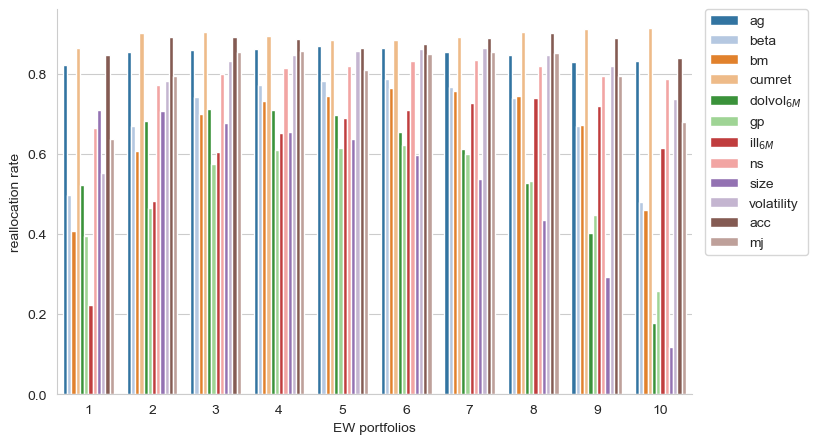

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & port1 & port2 & port3 & port4 & port5 & port6 & port7 & port8 & port9 & port10 \\
factor &  &  &  &  &  &  &  &  &  &  \\
\midrule
acc & 0.85 & 0.89 & 0.89 & 0.89 & 0.87 & 0.87 & 0.89 & 0.90 & 0.89 & 0.84 \\
ag & 0.82 & 0.86 & 0.86 & 0.86 & 0.87 & 0.87 & 0.85 & 0.85 & 0.83 & 0.83 \\
beta & 0.50 & 0.67 & 0.74 & 0.77 & 0.78 & 0.79 & 0.77 & 0.74 & 0.67 & 0.48 \\
bm & 0.41 & 0.61 & 0.70 & 0.73 & 0.74 & 0.77 & 0.76 & 0.75 & 0.67 & 0.46 \\
cumret & 0.86 & 0.90 & 0.90 & 0.89 & 0.89 & 0.88 & 0.89 & 0.90 & 0.91 & 0.92 \\
dolvol6 & 0.52 & 0.68 & 0.71 & 0.71 & 0.70 & 0.66 & 0.61 & 0.53 & 0.40 & 0.18 \\
gp & 0.39 & 0.47 & 0.58 & 0.61 & 0.61 & 0.62 & 0.60 & 0.53 & 0.45 & 0.26 \\
ill6 & 0.22 & 0.48 & 0.61 & 0.65 & 0.69 & 0.71 & 0.73 & 0.74 & 0.72 & 0.62 \\
mj & 0.64 & 0.79 & 0.85 & 0.86 & 0.81 & 0.85 & 0.85 & 0.85 & 0.80 & 0.68 \\
ns & 0.66 & 0.77 & 0.80 & 0.81 & 0.82 & 0.83 & 0.83 & 0.82 & 0.80 & 0.79 \\
size & 0.71 & 0.71 & 0.68 & 0.65 & 0.64 & 0.60 & 0.54 

In [16]:

from MJP.myplotMJ import * 
mybarplot(list_reallocation['even'], portfolio='portfolio', data_col='reallocation rate', factor='factor', nameplotx ='EW portfolios',
          save='Y', file_format='pdf', save_as=f'EW_reallocation_rates.pdf')

reshaped_EW_reallocation
print(reshaped_EW_reallocation.to_latex(float_format=lambda x: '{:.2f}'.format(x)))

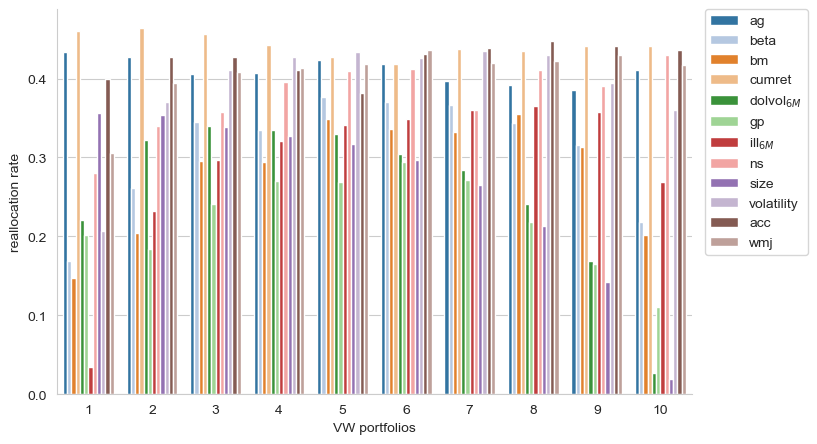

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & port1 & port2 & port3 & port4 & port5 & port6 & port7 & port8 & port9 & port10 \\
factor &  &  &  &  &  &  &  &  &  &  \\
\midrule
acc & 0.40 & 0.43 & 0.43 & 0.41 & 0.38 & 0.43 & 0.44 & 0.45 & 0.44 & 0.44 \\
ag & 0.43 & 0.43 & 0.41 & 0.41 & 0.42 & 0.42 & 0.40 & 0.39 & 0.39 & 0.41 \\
beta & 0.17 & 0.26 & 0.34 & 0.33 & 0.38 & 0.37 & 0.37 & 0.34 & 0.32 & 0.22 \\
bm & 0.15 & 0.20 & 0.30 & 0.29 & 0.35 & 0.34 & 0.33 & 0.35 & 0.31 & 0.20 \\
cumret & 0.46 & 0.46 & 0.46 & 0.44 & 0.43 & 0.42 & 0.44 & 0.43 & 0.44 & 0.44 \\
dolvol6 & 0.22 & 0.32 & 0.34 & 0.33 & 0.33 & 0.30 & 0.28 & 0.24 & 0.17 & 0.03 \\
gp & 0.20 & 0.18 & 0.24 & 0.27 & 0.27 & 0.29 & 0.27 & 0.22 & 0.17 & 0.11 \\
ill6 & 0.03 & 0.23 & 0.30 & 0.32 & 0.34 & 0.35 & 0.36 & 0.37 & 0.36 & 0.27 \\
ns & 0.28 & 0.34 & 0.36 & 0.40 & 0.41 & 0.41 & 0.36 & 0.41 & 0.39 & 0.43 \\
size & 0.36 & 0.35 & 0.34 & 0.33 & 0.32 & 0.30 & 0.26 & 0.21 & 0.14 & 0.02 \\
volatility & 0.21 & 0.37 & 0.41 & 0.43 & 0.43 & 0.43

In [17]:
mybarplot(list_reallocation['weighted'], portfolio='portfolio', data_col='reallocation rate', factor='factor', nameplotx ='VW portfolios',
          save='Y', file_format='pdf', save_as=f'VW_reallocation_rates.pdf')

print(reshaped_VW_reallocation.to_latex(float_format=lambda x: '{:.2f}'.format(x)))

# Main statistics and latex table

In [18]:
# ========================================================
# T-Value and P-Value
# ========================================================
# l’ipotesi nulla afferma che qualsiasi differenza tra la media della popolazione e la media campionaria 
# è dovuta al caso. Se il valore p del test t è inferiore a una certa soglia (ad esempio 0,05), 
# allora si può rifiutare l’ipotesi nulla e concludere che esiste una differenza significativa 
# tra la media della popolazione e la media campionaria. Altrimenti, non si può rifiutare l’ipotesi nulla 
# e si conclude che non c’è alcuna differenza significativa tra la media della popolazione e la media campionaria 
from scipy import stats

sharpe_ratios={}
sharpe_ratios['even']=[]
sharpe_ratios['weighted']=[]

volatilities={}
volatilities['even']=[]
volatilities['weighted']=[]

returns={}
returns['even']=[]
returns['weighted']=[]




for factor in factors+['mj']:
    sharpe_ratio_factor=np.sqrt(12)*(portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']]).mean()\
                                    /portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']].std()
    volatility_factor=np.sqrt(12)*(portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']].std())
    return_factor=12*(portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']].mean())
    for i in range(len(sharpe_ratio_factor.index)):
        if i!=len(sharpe_ratio_factor.index)-1: 
            sharpe_ratios['even'].append([factor,i+1,sharpe_ratio_factor.iloc[i]])
            volatilities['even'].append([factor,i+1,volatility_factor.iloc[i]])
            returns['even'].append([factor,i+1,return_factor.iloc[i]])
        else:
            sharpe_ratios['even'].append([factor,'long_short',sharpe_ratio_factor.iloc[i]])
            volatilities['even'].append([factor,'long_short',volatility_factor.iloc[i]])
            returns['even'].append([factor,'long_short',return_factor.iloc[i]])

sharpe_ratios['even']=pd.DataFrame(sharpe_ratios['even'])
sharpe_ratios['even'].columns=['factor','portfolio','sharpe ratio']
                                   
volatilities['even']=pd.DataFrame(volatilities['even'])
volatilities['even'].columns=['factor','portfolio','volatility']

returns['even']=pd.DataFrame(returns['even'])
returns['even'].columns=['factor','portfolio','returns']

for factor in factors+['wmj']:
    sharpe_ratio_factor=np.sqrt(12)*(weighted_portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']]).mean()\
                                    /weighted_portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']].std()
    volatility_factor=np.sqrt(12)*(weighted_portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']].std())
    return_factor=12*(weighted_portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']].mean())
    for i in range(len(sharpe_ratio_factor.index)):
        if i!=len(sharpe_ratio_factor.index)-1: 
            sharpe_ratios['weighted'].append([factor,i+1,sharpe_ratio_factor.iloc[i]])
            volatilities['weighted'].append([factor,i+1,volatility_factor.iloc[i]])
            returns['weighted'].append([factor,i+1,return_factor.iloc[i]])
        else:
            sharpe_ratios['weighted'].append([factor,'long_short',sharpe_ratio_factor.iloc[i]])
            volatilities['weighted'].append([factor,'long_short',volatility_factor.iloc[i]])
            returns['weighted'].append([factor,'long_short',return_factor.iloc[i]])

sharpe_ratios['weighted']=pd.DataFrame(sharpe_ratios['weighted'])
sharpe_ratios['weighted'].columns=['factor','portfolio','sharpe ratio']
                                   
                                                                      
volatilities['weighted']=pd.DataFrame(volatilities['weighted'])
volatilities['weighted'].columns=['factor','portfolio','volatility']

returns['weighted']=pd.DataFrame(returns['weighted'])
returns['weighted'].columns=['factor','portfolio','returns']

t_stat={}
p_val ={}
t_stat['even']=[]
p_val['even']=[]

t_stat['weighted']=[]
p_val['weighted']=[]


for factor in factors+['mj']:
    t = (stats.ttest_1samp(portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']],0.0))

    for i in range(len(t.statistic)):
        if i!=len(t.statistic)-1: 
            t_stat['even'].append([factor,i+1,t.statistic[i]])
            p_val['even'].append([factor,i+1,t.pvalue[i]])
        else:
            t_stat['even'].append([factor,'long_short',t.statistic[i]])
            p_val['even'].append([factor,'long_short',t.pvalue[i]])
            
t_stat['even']=pd.DataFrame(t_stat['even'])
t_stat['even'].columns=['factor','portfolio','t-stat']
p_val['even']=pd.DataFrame( p_val['even'])
p_val['even'].columns=['factor','portfolio','p-value']
#ewp_ttest = pd.merge(t_stat['even'],p_val['even'],  on=['factor','portfolio'], how='left')

for factor in factors+['wmj']:
    t = (stats.ttest_1samp(weighted_portfolios[factor][[f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']],0.0))

    for i in range(len(t.statistic)):
        if i!=len(t.statistic)-1: 
            t_stat['weighted'].append([factor,i+1,t.statistic[i]])
            p_val['weighted'].append([factor,i+1,t.pvalue[i]])
        else:
            t_stat['weighted'].append([factor,'long_short',t.statistic[i]])
            p_val['weighted'].append([factor,'long_short',t.pvalue[i]])
            
t_stat['weighted']=pd.DataFrame(t_stat['weighted'])
t_stat['weighted'].columns=['factor','portfolio','t-stat']
p_val['weighted']=pd.DataFrame( p_val['weighted'])
p_val['weighted'].columns=['factor','portfolio','p-value']

In [19]:
ewp_stat = pd.merge(returns['even'],t_stat['even'],  on=['factor','portfolio'], how='left')
ewp_stat = pd.merge(ewp_stat,volatilities['even'],  on=['factor','portfolio'], how='left')
ewp_stat = pd.merge(ewp_stat,sharpe_ratios['even'],  on=['factor','portfolio'], how='left')

vwp_stat = pd.merge(returns['weighted'], t_stat['weighted'],  on=['factor','portfolio'], how='left')
vwp_stat = pd.merge(vwp_stat,volatilities['weighted'],  on=['factor','portfolio'], how='left')
vwp_stat = pd.merge(vwp_stat,sharpe_ratios['weighted'],  on=['factor','portfolio'], how='left')

In [20]:
# Trasforma il DataFrame
df_melt = ewp_stat.melt(id_vars=['factor', 'portfolio'], var_name='variable', value_name='value')

# Crea una nuova tabella pivot
ew_tab = df_melt.pivot_table(index=['factor', 'variable'], columns='portfolio', values='value', sort=False)
ew_tab = ew_tab.rename(columns={'long_short': 'High-Low'})
#ew_tab

# Trasforma il DataFrame
df_melt = vwp_stat.melt(id_vars=['factor', 'portfolio'], var_name='variable', value_name='value')

# Crea una nuova tabella pivot
vw_tab = df_melt.pivot_table(index=['factor', 'variable'], columns='portfolio', values='value', sort=False)
vw_tab = vw_tab.rename(columns={'long_short': 'High-Low'})
#vw_tab

In [21]:
vw_tab

portfolio                       1         2         3         4         5  \
factor     variable                                                         
ag         returns       0.111450  0.093703  0.110415  0.078967  0.091316   
           t-stat        2.666653  2.528894  3.355412  2.452621  2.830744   
           volatility    0.202605  0.179622  0.159521  0.156081  0.156380   
           sharpe ratio  0.550089  0.521671  0.692169  0.505937  0.583938   
beta       returns       0.075870  0.078586  0.080359  0.100488  0.103460   
           t-stat        3.344958  3.029743  2.719072  3.081689  2.778358   
           volatility    0.109954  0.125740  0.143267  0.158074  0.180516   
           sharpe ratio  0.690012  0.624988  0.560902  0.635704  0.573132   
bm         returns       0.068703  0.071965  0.084967  0.084723  0.088650   
           t-stat        1.657117  1.988787  2.407164  2.623536  2.734090   
           volatility    0.200982  0.175415  0.171112  0.156548  0.157181   
           sharpe ratio  0.341837  0.410255  0.496560  0.541194  0.564000   
cumret     returns       0.111806  0.129642  0.075940  0.087748  0.092776   
           t-stat        1.649128  2.363497  1.668748  2.429166  2.656234   
           volatility    0.328657  0.265905  0.220605  0.175111  0.169319   
           sharpe ratio  0.340189  0.487552  0.344237  0.501099  0.547939   
dolvol6    returns       0.115641  0.111058  0.108855  0.115043  0.122667   
           t-stat        2.963308  2.497076  2.475011  2.693725  2.935263   
           volatility    0.189177  0.215602  0.213208  0.207034  0.202588   
           sharpe ratio  0.611284  0.515107  0.510556  0.555673  0.605498   
gp         returns      -0.003819  0.063866  0.067767  0.089332  0.092330   
           t-stat       -0.077489  1.709606  1.640834  2.392317  2.670503   
           volatility    0.238919  0.181097  0.200211  0.181017  0.167604   
           sharpe ratio -0.015985  0.352665  0.338478  0.493497  0.550883   
ill6       returns       0.072138  0.102062  0.096727  0.119665  0.111003   
           t-stat        2.243338  2.664451  2.400779  2.867736  2.545141   
           volatility    0.155884  0.185691  0.195313  0.202284  0.211425   
           sharpe ratio  0.462765  0.549634  0.495243  0.591569  0.525023   
ns         returns       0.124673  0.092727  0.088623  0.076948  0.075976   
           t-stat        3.658541  3.035459  2.982425  2.284061  2.075163   
           volatility    0.165196  0.148087  0.144049  0.163315  0.177483   
           sharpe ratio  0.754699  0.626167  0.615227  0.471166  0.428073   
size       returns       0.079699  0.106752  0.103786  0.115697  0.116345   
           t-stat        1.427717  1.915350  1.934948  2.344436  2.432517   
           volatility    0.270612  0.270186  0.260019  0.239231  0.231860   
           sharpe ratio  0.294516  0.395107  0.399149  0.483620  0.501790   
volatility returns       0.089514  0.086760  0.064738  0.082016  0.093151   
           t-stat        3.708812  2.743811  1.861840  2.111646  2.247328   
           volatility    0.117002  0.153286  0.168558  0.188284  0.200935   
           sharpe ratio  0.765069  0.566005  0.384068  0.435599  0.463588   
acc        returns       0.084262  0.078261  0.081759  0.090528  0.097125   
           t-stat        1.784556  1.902268  2.203526  2.815597  3.117773   
           volatility    0.228894  0.199437  0.179866  0.155864  0.151015   
           sharpe ratio  0.368126  0.392408  0.454553  0.580813  0.643148   
wmj        returns       0.049570  0.062013  0.090358  0.099777  0.081978   
           t-stat        1.172267  1.682152  2.645464  3.112115  2.189853   
           volatility    0.204985  0.178710  0.165577  0.155420  0.181475   
           sharpe ratio  0.241820  0.347001  0.545717  0.641980  0.451732   

portfolio                       6         7         8         9        10  \
factor     variable                                                     

In [22]:
def highlight_rows(s, names):
    is_in_list = s.name[0] in names
    return ['background-color: aliceblue' if is_in_list else '' for v in s]

names1 = ['beta','bm','cumret','gp','ill6','wmj']  # replace with your list of names
names2 = ['ag','dolvol6','ns','size', 'volatility','acc'] 

ew_tab1 = ew_tab.style.apply(highlight_rows, subset=[10], args=(names1,), axis=1)
ew_tab1 = ew_tab1.apply(highlight_rows, subset=[1], args=(names2,), axis=1)

vw_tab1 = vw_tab.style.apply(highlight_rows, subset=[10], args=(names1,), axis=1)
vw_tab1 = vw_tab1.apply(highlight_rows, subset=[1], args=(names2,), axis=1)

ew_p_val =p_val['even'].pivot_table(index=['factor'], columns='portfolio', values='p-value')
ew_p_val = ew_p_val.rename(columns={'long_short': 'High-Low'})

vw_p_val =p_val['weighted'].pivot_table(index=['factor'], columns='portfolio', values='p-value')
vw_p_val = vw_p_val.rename(columns={'long_short': 'High-Low'})



def format_t_statistic(df, pvalue_df):
    # Creiamo una copia del dataframe per non modificarlo
    df_copy = df.copy()
    for index, row in df.iterrows():
        # Otteniamo il fattore corrispondente (ag o beta)
        factor = index[0]

        # Iteriamo su ogni elemento della riga
        for col in row.index:
            # Otteniamo il valore e il corrispondente p-value
            value = row[col]
            p_value = pvalue_df.loc[factor, col]
            

            # Se l'indice contiene 'returns'
            if 'returns' in index:
                df_copy.loc[index, col] = '{:.4f}'.format(value)
                # Se il p-value è minore di 0.05, mettiamo il t-stat in grassetto e tra parentesi
                if p_value < 0.05:
                    df_copy.loc[index, col] = '\\textbf{{{:.4f}}}'.format(value)
            elif 'sharpe ratio' in index or 'volatility' in index:
                df_copy.loc[index, col] = '{:.4f}'.format(value)
                
            if 't-stat' in index:
                df_copy.loc[index, col] = '({:.3f})'.format(value)
    return df_copy
tabew = format_t_statistic(ew_tab, ew_p_val)
tabvw = format_t_statistic(vw_tab, vw_p_val)



EWtab1=tabew.iloc[:, :1]
EWtab10=tabew.iloc[:, 9:]
EWtt = EWtab1.join(EWtab10).reset_index()
EWtt.index.name = None

EWtt = EWtt.melt(id_vars=['factor', 'variable'], 
                    value_vars=[1, 10, 'High-Low'], 
                    var_name='port', value_name='value')

condition_1 = EWtt['factor'].isin(['ag', 'dolvol6','ns','size','volatility','acc']) & (EWtt['port'] == 10)
condition_10 = EWtt['factor'].isin(['beta', 'bm','cumret','gp','ill6','mj']) & (EWtt['port'] == 1)
EWtt = EWtt[~(condition_1 | condition_10)]
EWtt['port'] = EWtt['port'].replace({1: 'best', 10: 'best'})


EWpivot_table = EWtt.pivot_table(index=['port', 'variable'], 
                             columns='factor', 
                             values='value', 
                             aggfunc='first',  # or 'sum' for string concatenation
                             sort=False)
EWpivot_table = EWpivot_table.reindex(sorted(EWpivot_table.columns), axis=1)
new_cols = [col for col in EWpivot_table.columns if col != 'mj'] + ['mj']
EWpivot_table = EWpivot_table[new_cols]

VWtab1=tabvw.iloc[:, :1]
VWtab10=tabvw.iloc[:, 9:]
VWtt = VWtab1.join(VWtab10).reset_index()
VWtt.index.name = None

VWtt = VWtt.melt(id_vars=['factor', 'variable'], 
                    value_vars=[1, 10, 'High-Low'], 
                    var_name='port', value_name='value')

condition_1 = VWtt['factor'].isin(['ag', 'dolvol6','ns','size','volatility','acc']) & (VWtt['port'] == 10)
condition_10 = VWtt['factor'].isin(['beta', 'bm','cumret','gp','ill6','wmj']) & (VWtt['port'] == 1)
VWtt = VWtt[~(condition_1 | condition_10)]
VWtt['port'] = VWtt['port'].replace({1: 'best', 10: 'best'})


VWpivot_table = VWtt.pivot_table(index=['port', 'variable'], 
                             columns='factor', 
                             values='value', 
                             aggfunc='first',  # or 'sum' for string concatenation
                             sort=False)

VWpivot_table = VWpivot_table.reindex(sorted(VWpivot_table.columns), axis=1)
print(EWpivot_table.to_latex())
print(VWpivot_table.to_latex())

EWpivot_table

\begin{tabular}{llllllllllllll}
\toprule
 & factor & acc & ag & beta & bm & cumret & dolvol6 & gp & ill6 & ns & size & volatility & mj \\
port & variable &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{best} & returns & 0.0824 & 0.0942 & 0.0703 & \textbf{0.1576} & 0.0555 & \textbf{0.1201} & \textbf{0.1202} & \textbf{0.1061} & \textbf{0.1365} & 0.0869 & \textbf{0.1036} & \textbf{0.1246} \\
 & t-stat & (1.522) & (1.575) & (0.862) & (2.599) & (1.005) & (2.792) & (2.611) & (2.176) & (3.217) & (1.528) & (4.052) & (2.661) \\
 & volatility & 0.2625 & 0.2899 & 0.3954 & 0.2939 & 0.2680 & 0.2085 & 0.2232 & 0.2363 & 0.2056 & 0.2758 & 0.1240 & 0.2269 \\
 & sharpe ratio & 0.3139 & 0.3248 & 0.1779 & 0.5361 & 0.2073 & 0.5759 & 0.5386 & 0.4490 & 0.6637 & 0.3151 & 0.8359 & 0.5489 \\
\cline{1-14}
\multirow[t]{4}{*}{High-Low} & returns & 0.0017 & \textbf{0.0710} & -0.0078 & \textbf{0.0892} & -0.0430 & 0.0488 & \textbf{0.1166} & 0.0276 & \textbf{0.1289} & 0.0055 & 0.0546 & \textbf{0.106

factor                     acc               ag      beta               bm  \
port     variable                                                            
best     returns        0.0824           0.0942    0.0703  \textbf{0.1576}   
         t-stat        (1.522)          (1.575)   (0.862)          (2.599)   
         volatility     0.2625           0.2899    0.3954           0.2939   
         sharpe ratio   0.3139           0.3248    0.1779           0.5361   
High-Low returns        0.0017  \textbf{0.0710}   -0.0078  \textbf{0.0892}   
         t-stat        (0.111)          (2.715)  (-0.130)          (2.619)   
         volatility     0.0726           0.1267    0.2914           0.1650   
         sharpe ratio   0.0228           0.5602   -0.0267           0.5403   

factor                   cumret          dolvol6               gp  \
port     variable                                                   
best     returns         0.0555  \textbf{0.1201}  \textbf{0.1202}   
         t-stat         (1.005)          (2.792)          (2.611)   
         volatility      0.2680           0.2085           0.2232   
         sharpe ratio    0.2073           0.5759           0.5386   
High-Low returns        -0.0430           0.0488  \textbf{0.1166}   
         t-stat        (-0.875)          (1.690)          (3.298)   
         volatility      0.2384           0.1399           0.1713   
         sharpe ratio   -0.1805           0.3485           0.6803   

factor                            ill6               ns     size  \
port     variable                                                  
best     returns       \textbf{0.1061}  \textbf{0.1365}   0.0869   
         t-stat                (2.176)          (3.217)  (1.528)   
         volatility             0.2363           0.2056   0.2758   
         sharpe ratio           0.4490           0.6637   0.3151   
High-Low returns                0.0276  \textbf{0.1289}   0.0055   
         t-stat                (0.943)          (3.382)  (0.146)   
         volatility             0.1420           0.1847   0.1820   
         sharpe ratio           0.1945           0.6976   0.0301   

factor                      volatility               mj  
port     variable                                        
best     returns       \textbf{0.1036}  \textbf{0.1246}  
         t-stat                (4.052)          (2.661)  
         volatility             0.1240           0.2269  
         sharpe ratio           0.8359           0.5489  
High-Low returns                0.0546  \textbf{0.1063}  
         t-stat                (0.858)          (3.001)  
         volatility             0.3087           0.1718  
         sharpe ratio           0.1770           0.6190

In [23]:

ew_tab1 = tabew.style.apply(highlight_rows, subset=[10], args=(names1+['mj'],), axis=1)
ew_tab1 = ew_tab1.apply(highlight_rows, subset=[1], args=(names2,), axis=1)

vw_tab1 = tabvw.style.apply(highlight_rows, subset=[10], args=(names1+['wmj'],), axis=1)
vw_tab1 = vw_tab1.apply(highlight_rows, subset=[1], args=(names2,), axis=1)

ew_tex = ew_tab1.to_latex()
vw_tex = vw_tab1.to_latex()

# Replace '\background-coloraliceblue' with '\cellcolor{gray!25}'
ew_tex = ew_tex.replace("\\background-coloraliceblue", "\\cellcolor{lightgray}")
vw_tex = vw_tex.replace("\\background-coloraliceblue", "\\cellcolor{lightgray}")
ew_tex = ew_tex.replace("\\multirow[c]", " \\cline{1-13} \\multirow[c]")
vw_tex = vw_tex.replace("\\multirow[c]", " \\cline{1-13} \\multirow[c]")


#print(ew_tex)
print(vw_tex)

\begin{tabular}{lllllllllllll}
 & portfolio & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & High-Low \\
factor & variable &  &  &  &  &  &  &  &  &  &  &  \\
 \cline{1-13} \multirow[c]{4}{*}{ag} & returns & \cellcolor{lightgray} \textbf{0.1115} & \textbf{0.0937} & \textbf{0.1104} & \textbf{0.0790} & \textbf{0.0913} & \textbf{0.0788} & \textbf{0.0885} & \textbf{0.0972} & 0.0736 & 0.0243 & \textbf{0.0872} \\
 & t-stat & \cellcolor{lightgray} (2.667) & (2.529) & (3.355) & (2.453) & (2.831) & (2.603) & (2.597) & (2.329) & (1.697) & (0.474) & (2.433) \\
 & volatility & \cellcolor{lightgray} 0.2026 & 0.1796 & 0.1595 & 0.1561 & 0.1564 & 0.1467 & 0.1653 & 0.2024 & 0.2103 & 0.2479 & 0.1737 \\
 & sharpe ratio & \cellcolor{lightgray} 0.5501 & 0.5217 & 0.6922 & 0.5059 & 0.5839 & 0.5369 & 0.5356 & 0.4804 & 0.3501 & 0.0979 & 0.5019 \\
 \cline{1-13} \multirow[c]{4}{*}{beta} & returns & \textbf{0.0759} & \textbf{0.0786} & \textbf{0.0804} & \textbf{0.1005} & \textbf{0.1035} & \textbf{0.1166} & \textbf{0.092

# Factor Models

In [24]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import datetime as dt
from datetime import datetime
from pandas.tseries.offsets import *

# create a dataframe with best portfolios

def best_port(portfolios):
    Y = pd.DataFrame()

    # Itera attraverso ogni elemento nel dizionario
    for factor, ports in portfolios.items():
        if (factor == 'mj') or (factor == 'wmj'):
             port_key = 'port10'
        else:
            pos=factors.index(factor)
            # Scegli 'port1' o 'port10' in base al valore di 'factor'
            port_key = 'port10' if signs[pos] ==1  else 'port1'
    
        # Aggiungi i dati al DataFrame
        Y[factor] = ports[port_key]
    return Y

def multiple_regression_table(df, X_label, Y_label):
    Y=df[Y_label]
    X=df[X_label]
    # add constant on regressor matrix
    X = sm.add_constant(X)

    pvalues_df = pd.DataFrame()
    results_df = pd.DataFrame()
    R_list = []
    
    
    for y in Y.columns:
        # Perform the regression
        model = sm.OLS(Y[y], X)

        # Fit the model
        results = model.fit()
        coef = results.params
        t_stats = results.tvalues
        p = results.pvalues
        R = results.rsquared
        pvalues_df[y] = p 
        R_list.append(R)
        
    
        for x in X.columns:
            results_df.loc[x, y] = '{:.3f}'.format(coef[x])
            results_df.loc[f't stat {x}', y] = '({:.3f})'.format(t_stats[x])

    R_df = pd.DataFrame([R_list], columns=results_df.columns, index=['$R^2$'])
    
    def format_to_3f(x):
        return f"{x:.3f}"

    # Apply the function to the DataFrame
    R_df = R_df.applymap(format_to_3f)

    results_df = pd.concat([results_df, R_df], axis=0)
    # Create a LaTeX table from the results DataFrame
    latex_table = results_df.to_latex(escape=False)

    # Bold the t-statistics if the corresponding p-value is less than 0.05
    for y in Y.columns:
        for x in X.columns:
            if pvalues_df.loc[x, y] < 0.05:
                latex_table = latex_table.replace(f'{results_df.loc[f"{x}", y]}', f'\\textbf{{{results_df.loc[f"{x}", y]}}}')
                latex_table = latex_table.replace(f"t stat {x}", " ")
                
    return results_df, pvalues_df, latex_table, R_list

# equal - weighted
def create_df_factor_regression(portfolios):
    dataFF = pd.read_csv("./dataset_creation/original_data/FF_Research_Data_Factors_monthly.csv")
    mom = pd.read_csv("./dataset_creation/original_data/F-F_Momentum_Factor.csv")
    dataFF4F = pd.merge(dataFF, mom, on='date', how='inner')
    dataFF4F['date'] = pd.to_datetime(dataFF4F['date'],format='%Y%m')+pd.tseries.offsets.MonthEnd()
    dataFF4F['date'] = dataFF4F['date'] + MonthEnd(0)

    FFfactors=list(set(dataFF4F.columns)-set(['date']))
    dataFF4F[FFfactors]=dataFF4F[FFfactors]/100
    
    flat_portfolios=portfolios.reset_index()
    flat_portfolios.rename(columns={'medate':'date'},inplace=True)
    
    data_4fmodel=pd.merge(dataFF4F,flat_portfolios,on='date', how='inner')
    data_4fmodel.set_index('date',inplace=True)
    return data_4fmodel


0.016837500000000005


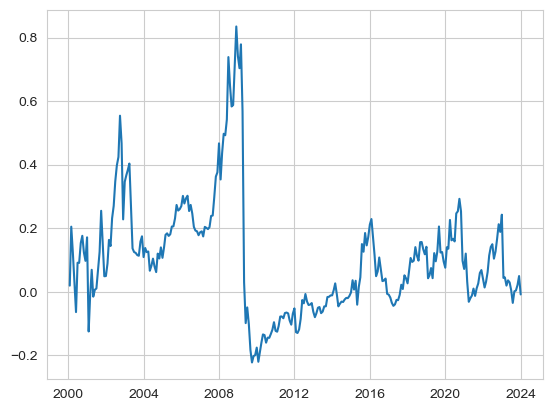

In [25]:
# MOMENTUM - FF portfolio
momFF = pd.read_csv("./dataset_creation/original_data/F-F_Momentum_Factor.csv")
momFF['date'] = pd.to_datetime(momFF['date'],format='%Y%m')+pd.tseries.offsets.MonthEnd()
momFF['date'] = momFF['date'] + MonthEnd(0)
momFF['MOM'] = momFF['MOM']/100
momFF=momFF.loc[(momFF.date >= date_initial) & (momFF.date <= date_final)].reset_index(drop = True)
#print(plt.plot(momFF['date'], momFF['MOM']))
print(momFF['MOM'].mean()*12)
momFF['cret_mom'] = (1 + momFF['MOM']).cumprod() - 1
plt.plot(momFF['date'], momFF['cret_mom'])
plt.show()

In [26]:

df_regression=create_df_factor_regression(portfolios['mj'])

# CAPM
Y_label = portfolios['mj'].columns
X_label = ['Mkt_RF']
results_dfCAPM, pvalues_dfCAPM, latex_tableCAPM, R2 = multiple_regression_table(df_regression, X_label, Y_label)
latex_tableCAPM = latex_tableCAPM.replace("Mkt_RF", "Mkt-RF")
latex_tableCAPM = latex_tableCAPM.replace("const", "CAPM $\\alpha$")

print(latex_tableCAPM)

#3-Factor model
X_label = ['Mkt_RF', 'SMB', 'HML']
results_df3f, pvalues_df3, latex_table3, R3 = multiple_regression_table(df_regression, X_label, Y_label)
latex_table3 = latex_table3.replace("Mkt_RF", "Mkt-RF")
latex_table3 = latex_table3.replace("const", "3-factor $\\alpha$")

print(latex_table3)
#print(results_df3f)

# 4-Factor model
X_label = ['Mkt_RF', 'SMB', 'HML', 'MOM']
results_df, pvalues_df, latex_table, R4 = multiple_regression_table(df_regression, X_label, Y_label)
latex_table = latex_table.replace("Mkt_RF", "Mkt-RF")
latex_table = latex_table.replace("const", "4-factor $\\alpha$")

print(latex_table)
#results_df

\begin{tabular}{llllllllllll}
\toprule
 & port1 & port2 & port3 & port4 & port5 & port6 & port7 & port8 & port9 & port10 & long_short \\
\midrule
CAPM $\alpha$ & \textbf{-0.007} & -0.001 & 0.001 & 0.001 & 0.002 & \textbf{0.003} & \textbf{0.003} & \textbf{0.003} & 0.004 & 0.004 & \textbf{0.011} \\
  & (-3.001) & (-0.648) & (0.331) & (0.489) & (1.033) & (1.812) & (1.986) & (1.690) & (1.912) & (1.663) & (3.655) \\
Mkt-RF & \textbf{1.481} & \textbf{1.317} & \textbf{1.285} & \textbf{1.260} & \textbf{1.272} & \textbf{1.226} & \textbf{1.227} & \textbf{1.216} & \textbf{1.252} & \textbf{1.195} & \textbf{-0.286} \\
  & (29.590) & (33.315) & (39.179) & (37.044) & (36.272) & (33.748) & (33.065) & (33.375) & (29.883) & (26.300) & (-4.624) \\
$R^2$ & 0.758 & 0.799 & 0.846 & 0.831 & 0.825 & 0.803 & 0.796 & 0.799 & 0.761 & 0.712 & 0.071 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllllllllll}
\toprule
 & port1 & port2 & port3 & port4 & port5 & port6 & port7 & port8 & port9 & port10 & long_short \\


In [27]:
# value - weighted
# CAPM
df_regression=create_df_factor_regression(weighted_portfolios['wmj'])

X_label = ['Mkt_RF']
wresults_dfCAPM, wpvalues_dfCAPM, wlatex_tableCAPM, wR2 = multiple_regression_table(df_regression, X_label, Y_label)
wlatex_tableCAPM = wlatex_tableCAPM.replace("Mkt_RF", "Mkt-RF")
wlatex_tableCAPM = wlatex_tableCAPM.replace("const", "CAPM $\\alpha$")
print(wlatex_tableCAPM)

#3-Factor model
X_label = ['Mkt_RF', 'SMB', 'HML']
wresults_df3f, wpvalues_df3, wlatex_table3, wR3 = multiple_regression_table(df_regression, X_label, Y_label)
wlatex_table3 = wlatex_table3.replace("Mkt_RF", "Mkt-RF")
wlatex_table3 = wlatex_table3.replace("const", "3-factor $\\alpha$")

print(wlatex_table3)

# 4-Factor model
X_label = ['Mkt_RF', 'SMB', 'HML', 'MOM']
wresults_df, wpvalues_df, wlatex_table, wR4 = multiple_regression_table(df_regression, X_label, Y_label)
wlatex_table = wlatex_table.replace("Mkt_RF", "Mkt-RF")
wlatex_table = wlatex_table.replace("const", "4-factor $\\alpha$")

print(wlatex_table)

\begin{tabular}{llllllllllll}
\toprule
 & port1 & port2 & port3 & port4 & port5 & port6 & port7 & port8 & port9 & port10 & long_short \\
\midrule
CAPM $\alpha$ & -\textbf{\textbf{\textbf{0.003}}} & -0.001 & 0.002 & \textbf{\textbf{\textbf{0.003}}} & 0.001 & \textbf{\textbf{\textbf{0.003}}} & \textbf{0.004} & 0.001 & \textbf{\textbf{\textbf{0.003}}} & \textbf{0.005} & \textbf{0.008} \\
  & (-1.650) & (-0.676) & (1.885) & (3.333) & (0.683) & (2.018) & (2.367) & (0.664) & (2.008) & (2.776) & (2.786) \\
Mkt-RF & \textbf{1.157} & \textbf{1.035} & \textbf{0.959} & \textbf{0.911} & \textbf{1.044} & \textbf{0.996} & \textbf{0.962} & \textbf{0.980} & \textbf{1.064} & \textbf{0.927} & \textbf{-0.230} \\
  & (35.342) & (41.731) & (41.590) & (45.891) & (39.635) & (34.151) & (28.806) & (31.234) & (31.415) & (23.271) & (-3.893) \\
$R^2$ & 0.817 & 0.861 & 0.861 & 0.883 & 0.849 & 0.806 & 0.748 & 0.777 & 0.779 & 0.659 & 0.051 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllllllllll}
\toprule
 & port1